# 08. Correlation Analysis: News Sentiment and Stock Movement

This notebook analyzes the correlation between news sentiment and stock price movements.

**Sections:**
1. **Data Loading and Preparation** - Load news and stock data, align dates
2. **Sentiment Analysis** - Perform sentiment analysis on headlines using NLTK, TextBlob, and VADER
3. **Stock Movement Calculation** - Calculate daily stock returns
4. **Correlation Analysis** - Aggregate daily sentiments and calculate correlation with stock returns

**Dependencies:** 
- Run `01_Data_Loading_and_Setup.ipynb` first for processed news data
- Run `07_Quantitative_Analysis.ipynb` for stock price data (optional)
- Stock price data files in `data/` directory

**Stocks Analyzed:** AAPL, AMZN, GOOG, META, MSFT, NVDA


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Sentiment Analysis libraries
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

# Download required NLTK data
print("Downloading NLTK data...")
try:
    try:
        nltk.download('punkt_tab', quiet=True)
        print("Downloaded punkt_tab")
    except Exception as e1:
        try:
            nltk.download('punkt', quiet=True)
            print("Downloaded punkt (fallback)")
        except Exception as e2:
            print(f"Warning: Could not download punkt: {e2}")
    
    try:
        nltk.download('stopwords', quiet=True)
        print("Downloaded stopwords")
    except Exception as e:
        print(f"Warning: Could not download stopwords: {e}")
    
    print("NLTK data ready!")
except Exception as e:
    print(f"NLTK download error: {e}")

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

print("\nLibraries imported successfully!")


Plotting style configured
Downloaded punkt_tab
Downloaded stopwords
NLTK data ready!

Libraries imported successfully!


## 1. Data Loading and Preparation

**Objective:** Load news and stock price data, then align dates to ensure each news item matches the corresponding stock trading day.

**Key Steps:**
- Load processed news data
- Load stock price data for all stocks
- Normalize timestamps and align dates
- Handle missing dates and trading day matching


In [2]:
# Load processed news data
print("="*80)
print("LOADING NEWS DATA")
print("="*80)

try:
    df_news = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed news data: {df_news.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data, clean_data
    df_news = load_data('../data/raw_analyst_ratings.csv')
    df_news = clean_data(df_news, remove_duplicates=True, handle_missing='report', fix_dates=True)
    df_news = preprocess_data(df_news)
    print(f"Loaded and preprocessed news data: {df_news.shape}")

print(f"\nNews dataset shape: {df_news.shape}")
print(f"Columns: {list(df_news.columns)}")

# Ensure date is datetime
if not pd.api.types.is_datetime64_any_dtype(df_news['date']):
    df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')

# Extract date only (without time) for alignment
df_news['date_only'] = df_news['date'].dt.date

# Filter out invalid dates
df_news_valid = df_news[df_news['date'].notna()].copy()
print(f"\nValid news dates: {len(df_news_valid):,} ({len(df_news_valid)/len(df_news)*100:.2f}%)")
print(f"Date range: {df_news_valid['date'].min()} to {df_news_valid['date'].max()}")


LOADING NEWS DATA
Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed news data: (1407328, 8)

News dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']

Valid news dates: 55,987 (3.98%)
Date range: 2011-04-27 21:01:48-04:00 to 2020-06-11 17:12:35-04:00


In [4]:
# Load stock price data
print("\n" + "="*80)
print("LOADING STOCK PRICE DATA")
print("="*80)

STOCKS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
DATA_PATH = '../data/'

stock_data = {}

for stock in STOCKS:
    file_path = f"{DATA_PATH}{stock}.csv"
    try:
        df_stock = pd.read_csv(file_path)
        
        # Convert Date column to datetime
        if 'Date' in df_stock.columns:
            df_stock['Date'] = pd.to_datetime(df_stock['Date'])
            df_stock = df_stock.sort_values('Date').reset_index(drop=True)
            df_stock.set_index('Date', inplace=True)
            df_stock.index.name = 'date'
        
        # Extract date only
        df_stock['date_only'] = df_stock.index.date
        
        # Verify required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        if all(col in df_stock.columns for col in required_cols):
            stock_data[stock] = df_stock
            print(f"✓ {stock}: Loaded {len(df_stock):,} rows, Date range: {df_stock.index.min()} to {df_stock.index.max()}")
        else:
            print(f"⚠ {stock}: Missing required columns")
    except FileNotFoundError:
        print(f"✗ {stock}: File not found at {file_path}")
    except Exception as e:
        print(f"✗ {stock}: Error loading data - {e}")

print(f"\nSuccessfully loaded {len(stock_data)} stock datasets")



LOADING STOCK PRICE DATA
✓ AAPL: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ AMZN: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ GOOG: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ META: Loaded 2,923 rows, Date range: 2012-05-18 00:00:00 to 2023-12-29 00:00:00
✓ MSFT: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ NVDA: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00

Successfully loaded 6 stock datasets


In [5]:
# Date alignment: Normalize timestamps and match to trading days
print("\n" + "="*80)
print("DATE ALIGNMENT")
print("="*80)

# For news data: Convert to date only and ensure we're working with trading days
# Stock markets are typically closed on weekends, so we need to match news to trading days

# Get all trading days from stock data (union of all stock trading days)
all_trading_days = set()
for stock, df_stock in stock_data.items():
    trading_days = set(df_stock.index.date)
    all_trading_days.update(trading_days)

all_trading_days = sorted(list(all_trading_days))
print(f"Total unique trading days across all stocks: {len(all_trading_days):,}")
print(f"Trading day range: {all_trading_days[0]} to {all_trading_days[-1]}")

# Filter news data to only include dates that are trading days
df_news_valid['is_trading_day'] = df_news_valid['date_only'].isin(all_trading_days)
news_on_trading_days = df_news_valid[df_news_valid['is_trading_day']].copy()

print(f"\nNews articles on trading days: {len(news_on_trading_days):,} ({len(news_on_trading_days)/len(df_news_valid)*100:.2f}%)")
print(f"News articles on non-trading days: {(~df_news_valid['is_trading_day']).sum():,}")

# For correlation analysis, we'll use news on trading days
df_news_aligned = news_on_trading_days.copy()
print(f"\n✓ News data aligned to trading days: {len(df_news_aligned):,} articles")



DATE ALIGNMENT
Total unique trading days across all stocks: 3,774
Trading day range: 2009-01-02 to 2023-12-29

News articles on trading days: 55,230 (98.65%)
News articles on non-trading days: 757

✓ News data aligned to trading days: 55,230 articles


## 2. Sentiment Analysis

**Objective:** Perform sentiment analysis on headlines using multiple tools (NLTK, TextBlob, VADER) to quantify the tone of each article.

**Tools Used:**
- **TextBlob**: Polarity score (-1 to 1, where -1 is negative, 1 is positive)
- **VADER**: Compound score (-1 to 1, optimized for social media and financial text)
- **NLTK**: For text preprocessing

**Key Questions:**
- What is the distribution of sentiment scores?
- How do different sentiment analyzers compare?
- Are there differences in sentiment by stock or publisher?


In [6]:
# Perform sentiment analysis on headlines
print("="*80)
print("SENTIMENT ANALYSIS")
print("="*80)

# For efficiency, we'll analyze a sample if the dataset is very large
# You can adjust this or remove the sampling for full analysis
SAMPLE_SIZE = None  # Set to None for full analysis, or a number like 100000 for sampling

if SAMPLE_SIZE and len(df_news_aligned) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE:,} articles for sentiment analysis...")
    df_sentiment = df_news_aligned.sample(n=SAMPLE_SIZE, random_state=42).copy()
else:
    df_sentiment = df_news_aligned.copy()

print(f"Analyzing sentiment for {len(df_sentiment):,} headlines...")

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores
def calculate_textblob_sentiment(text):
    """Calculate TextBlob sentiment polarity"""
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity
    except:
        return 0.0

def calculate_vader_sentiment(text):
    """Calculate VADER sentiment compound score"""
    try:
        scores = vader_analyzer.polarity_scores(str(text))
        return scores['compound']
    except:
        return 0.0

# Apply sentiment analysis
print("\nCalculating TextBlob sentiment...")
df_sentiment['sentiment_textblob'] = df_sentiment['headline'].apply(calculate_textblob_sentiment)

print("Calculating VADER sentiment...")
df_sentiment['sentiment_vader'] = df_sentiment['headline'].apply(calculate_vader_sentiment)

# Create a combined sentiment score (average of both)
df_sentiment['sentiment_combined'] = (df_sentiment['sentiment_textblob'] + df_sentiment['sentiment_vader']) / 2

# Classify sentiment
def classify_sentiment(score):
    """Classify sentiment as positive, negative, or neutral"""
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df_sentiment['sentiment_label'] = df_sentiment['sentiment_combined'].apply(classify_sentiment)

print(f"\n✓ Sentiment analysis complete for {len(df_sentiment):,} headlines")


SENTIMENT ANALYSIS
Analyzing sentiment for 55,230 headlines...

Calculating TextBlob sentiment...
Calculating VADER sentiment...

✓ Sentiment analysis complete for 55,230 headlines


In [8]:
# Analyze sentiment distribution
print("\n" + "="*80)
print("SENTIMENT DISTRIBUTION ANALYSIS")
print("="*80)

print(f"\nSentiment Classification (Combined Score):")
sentiment_counts = df_sentiment['sentiment_label'].value_counts()
for label, count in sentiment_counts.items():
    pct = count / len(df_sentiment) * 100
    print(f"  {label:10s}: {count:>8,} ({pct:>5.2f}%)")

print(f"\nSentiment Score Statistics (Combined):")
print(f"  Mean:   {df_sentiment['sentiment_combined'].mean():.4f}")
print(f"  Median: {df_sentiment['sentiment_combined'].median():.4f}")
print(f"  Std:    {df_sentiment['sentiment_combined'].std():.4f}")
print(f"  Min:    {df_sentiment['sentiment_combined'].min():.4f}")
print(f"  Max:    {df_sentiment['sentiment_combined'].max():.4f}")

print(f"\nSentiment Score Statistics (TextBlob):")
print(f"  Mean:   {df_sentiment['sentiment_textblob'].mean():.4f}")
print(f"  Median: {df_sentiment['sentiment_textblob'].median():.4f}")

print(f"\nSentiment Score Statistics (VADER):")
print(f"  Mean:   {df_sentiment['sentiment_vader'].mean():.4f}")
print(f"  Median: {df_sentiment['sentiment_vader'].median():.4f}")

# Sentiment by stock
print(f"\n" + "="*80)
print("SENTIMENT BY STOCK")
print("="*80)
for stock in STOCKS:
    stock_news = df_sentiment[df_sentiment['stock'] == stock]
    if len(stock_news) > 0:
        mean_sent = stock_news['sentiment_combined'].mean()
        pos_pct = (stock_news['sentiment_label'] == 'positive').sum() / len(stock_news) * 100
        neg_pct = (stock_news['sentiment_label'] == 'negative').sum() / len(stock_news) * 100
        print(f"  {stock:6s}: Mean sentiment = {mean_sent:>6.4f}, Positive = {pos_pct:>5.2f}%, Negative = {neg_pct:>5.2f}%")



SENTIMENT DISTRIBUTION ANALYSIS

Sentiment Classification (Combined Score):
  neutral   :   28,794 (52.13%)
  positive  :   15,830 (28.66%)
  negative  :   10,606 (19.20%)

Sentiment Score Statistics (Combined):
  Mean:   0.0525
  Median: 0.0000
  Std:    0.1962
  Min:    -0.8125
  Max:    0.9295

Sentiment Score Statistics (TextBlob):
  Mean:   0.0375
  Median: 0.0000

Sentiment Score Statistics (VADER):
  Mean:   0.0676
  Median: 0.0000

SENTIMENT BY STOCK
  AAPL  : Mean sentiment = 0.1768, Positive = 60.00%, Negative =  0.00%
  AMZN  : Mean sentiment = 0.1902, Positive = 60.00%, Negative = 10.00%
  GOOG  : Mean sentiment = 0.0174, Positive = 20.00%, Negative = 20.00%
  NVDA  : Mean sentiment = 0.1805, Positive = 55.56%, Negative =  0.00%


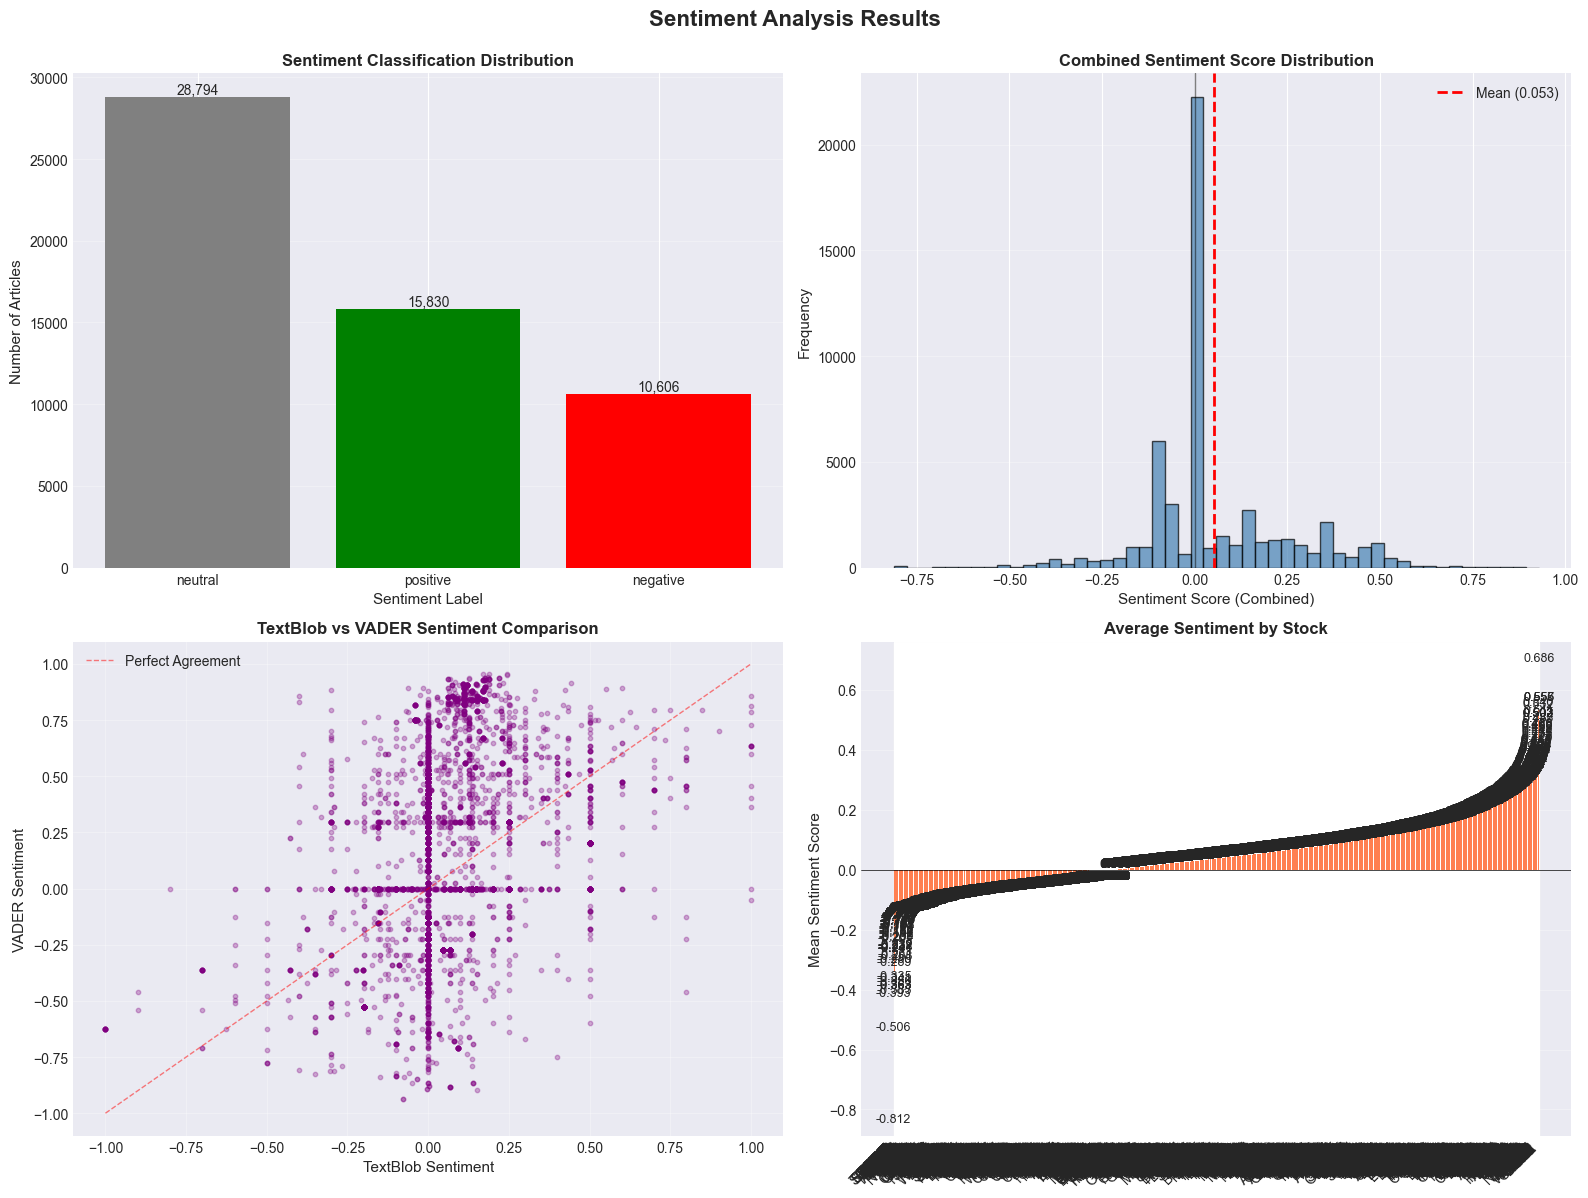

Saved: figures/sentiment_analysis.png


In [9]:
# Visualize sentiment distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Sentiment Analysis Results', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Sentiment classification distribution
ax1 = axes[0, 0]
sentiment_counts = df_sentiment['sentiment_label'].value_counts()
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values, 
               color=[colors.get(x, 'blue') for x in sentiment_counts.index])
ax1.set_xlabel('Sentiment Label', fontsize=11)
ax1.set_ylabel('Number of Articles', fontsize=11)
ax1.set_title('Sentiment Classification Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10)

# Plot 2: Combined sentiment score distribution
ax2 = axes[0, 1]
ax2.hist(df_sentiment['sentiment_combined'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(df_sentiment['sentiment_combined'].mean(), color='r', linestyle='--', linewidth=2, 
            label=f'Mean ({df_sentiment["sentiment_combined"].mean():.3f})')
ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.set_xlabel('Sentiment Score (Combined)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Combined Sentiment Score Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Comparison of TextBlob vs VADER
ax3 = axes[1, 0]
# Sample for scatter plot if too many points
if len(df_sentiment) > 10000:
    sample_df = df_sentiment.sample(n=10000, random_state=42)
else:
    sample_df = df_sentiment
ax3.scatter(sample_df['sentiment_textblob'], sample_df['sentiment_vader'], 
           alpha=0.3, s=10, color='purple')
ax3.plot([-1, 1], [-1, 1], 'r--', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax3.set_xlabel('TextBlob Sentiment', fontsize=11)
ax3.set_ylabel('VADER Sentiment', fontsize=11)
ax3.set_title('TextBlob vs VADER Sentiment Comparison', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Sentiment by stock
ax4 = axes[1, 1]
sentiment_by_stock = df_sentiment.groupby('stock')['sentiment_combined'].mean().sort_values()
bars = ax4.bar(range(len(sentiment_by_stock)), sentiment_by_stock.values, color='coral')
ax4.set_xticks(range(len(sentiment_by_stock)))
ax4.set_xticklabels(sentiment_by_stock.index, rotation=45, ha='right')
ax4.set_ylabel('Mean Sentiment Score', fontsize=11)
ax4.set_title('Average Sentiment by Stock', fontsize=12, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (stock, val) in enumerate(sentiment_by_stock.items()):
    ax4.text(i, val, f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('figures/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/sentiment_analysis.png")


## 3. Stock Movement Calculation

**Objective:** Calculate daily stock returns to represent stock movements.

**Key Steps:**
- Calculate daily percentage change in closing prices
- Handle missing trading days
- Analyze return distribution


In [11]:
# Calculate daily stock returns
print("="*80)
print("STOCK MOVEMENT CALCULATION")
print("="*80)

stock_returns = {}

for stock, df_stock in stock_data.items():
    # Calculate daily returns (percentage change)
    df_stock['daily_return'] = df_stock['Close'].pct_change() * 100  # Convert to percentage
    
    # Create returns dataframe with date
    returns_df = pd.DataFrame({
        'date': df_stock.index,
        'date_only': df_stock.index.date,
        'daily_return': df_stock['daily_return'],
        'close_price': df_stock['Close']
    })
    
    stock_returns[stock] = returns_df
    
    # Statistics
    returns_clean = returns_df['daily_return'].dropna()
    print(f"\n{stock}:")
    print(f"  Total trading days: {len(returns_df):,}")
    print(f"  Mean daily return: {returns_clean.mean():.4f}%")
    print(f"  Std dev: {returns_clean.std():.4f}%")
    print(f"  Min return: {returns_clean.min():.4f}%")
    print(f"  Max return: {returns_clean.max():.4f}%")
    print(f"  Positive days: {(returns_clean > 0).sum():,} ({(returns_clean > 0).sum()/len(returns_clean)*100:.2f}%)")
    print(f"  Negative days: {(returns_clean < 0).sum():,} ({(returns_clean < 0).sum()/len(returns_clean)*100:.2f}%)")

print(f"\n✓ Daily returns calculated for {len(stock_returns)} stocks")


STOCK MOVEMENT CALCULATION

AAPL:
  Total trading days: 3,774
  Mean daily return: 0.1289%
  Std dev: 1.8010%
  Min return: -12.8647%
  Max return: 11.9808%
  Positive days: 2,003 (53.09%)
  Negative days: 1,763 (46.73%)

AMZN:
  Total trading days: 3,774
  Mean daily return: 0.1303%
  Std dev: 2.1829%
  Min return: -14.0494%
  Max return: 26.7951%
  Positive days: 1,981 (52.50%)
  Negative days: 1,784 (47.28%)

GOOG:
  Total trading days: 3,774
  Mean daily return: 0.0910%
  Std dev: 1.7334%
  Min return: -11.1008%
  Max return: 16.0524%
  Positive days: 1,991 (52.77%)
  Negative days: 1,781 (47.20%)

META:
  Total trading days: 2,923
  Mean daily return: 0.1082%
  Std dev: 2.5280%
  Min return: -26.3901%
  Max return: 29.6115%
  Positive days: 1,526 (52.22%)
  Negative days: 1,385 (47.40%)

MSFT:
  Total trading days: 3,774
  Mean daily return: 0.0996%
  Std dev: 1.6885%
  Min return: -14.7391%
  Max return: 14.2169%
  Positive days: 1,981 (52.50%)
  Negative days: 1,759 (46.62%)

NV

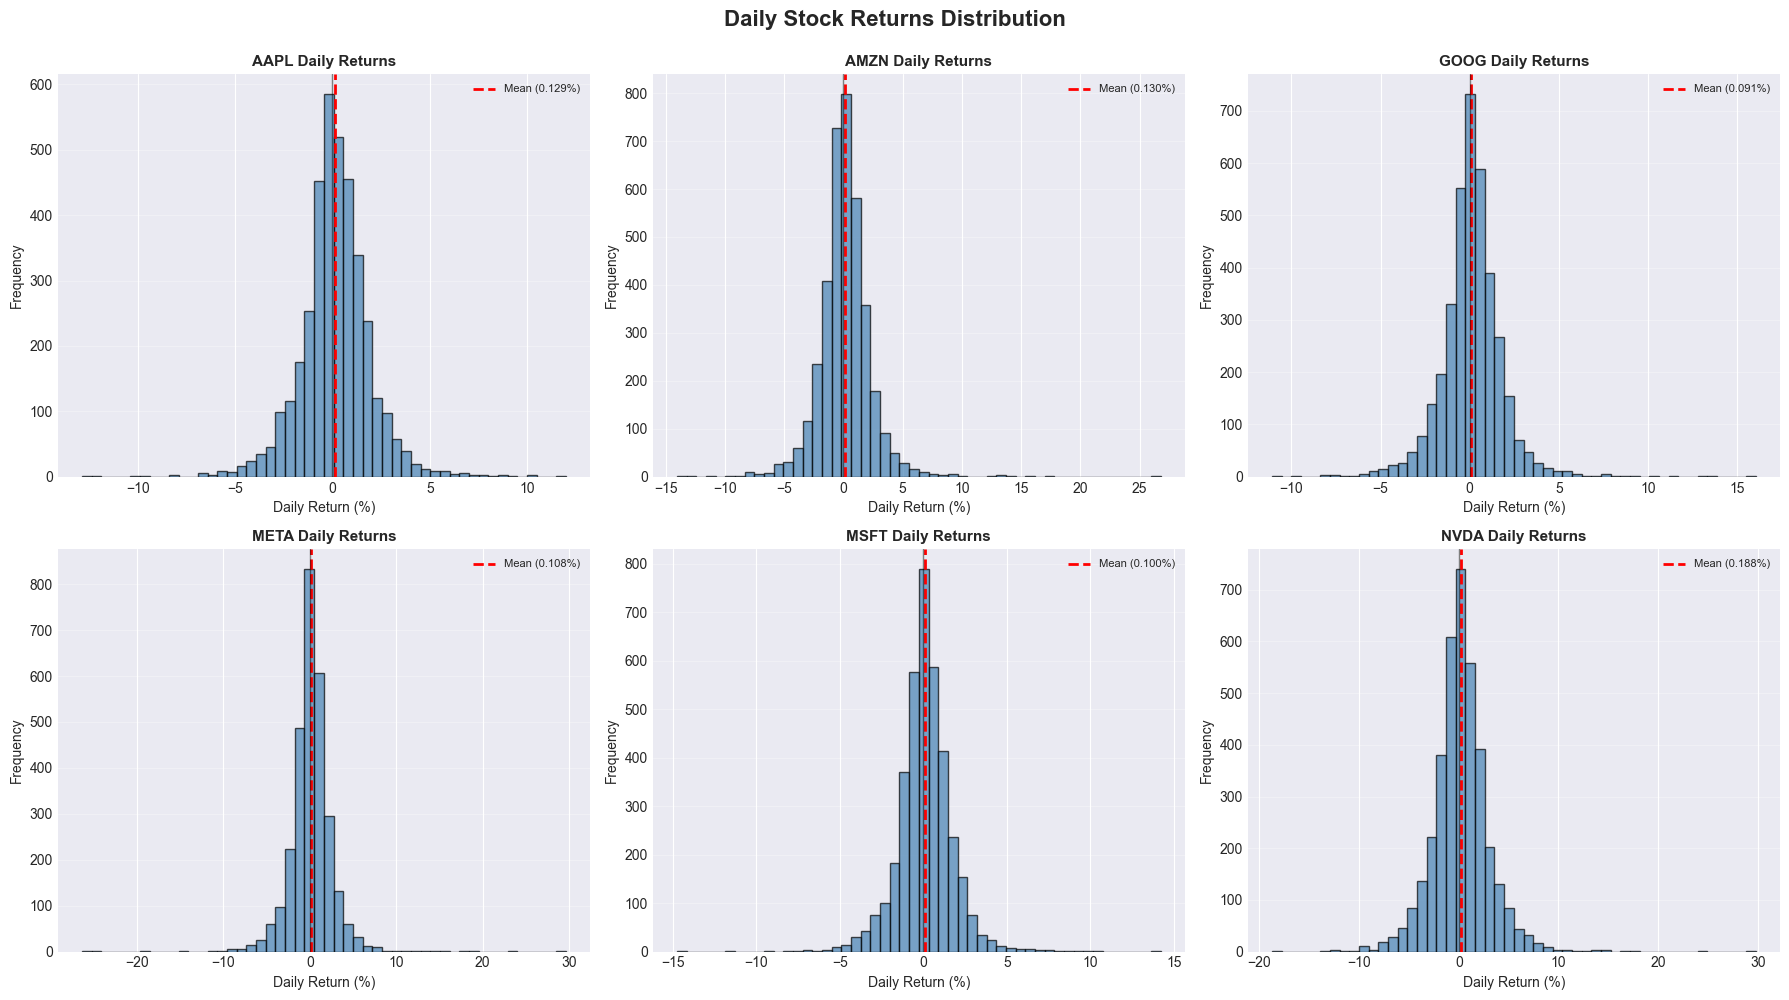

Saved: figures/stock_returns_distribution.png


In [12]:
# Visualize stock returns distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Daily Stock Returns Distribution', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, (stock, returns_df) in enumerate(stock_returns.items()):
    ax = axes[idx]
    returns_clean = returns_df['daily_return'].dropna()
    
    ax.hist(returns_clean, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(returns_clean.mean(), color='r', linestyle='--', linewidth=2, 
              label=f'Mean ({returns_clean.mean():.3f}%)')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_xlabel('Daily Return (%)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{stock} Daily Returns', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/stock_returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/stock_returns_distribution.png")


## 4. Correlation Analysis

**Objective:** Aggregate daily sentiments and calculate correlation between news sentiment and stock returns.

**Key Steps:**
- Aggregate daily sentiment scores (average if multiple articles per day)
- Match sentiment scores to stock returns by date and stock
- Calculate Pearson correlation coefficient
- Perform statistical significance testing
- Analyze correlation patterns


In [13]:
# Aggregate daily sentiments
print("="*80)
print("AGGREGATING DAILY SENTIMENTS")
print("="*80)

# Group by date and stock, calculate average sentiment
daily_sentiments = df_sentiment.groupby(['date_only', 'stock']).agg({
    'sentiment_combined': 'mean',
    'sentiment_textblob': 'mean',
    'sentiment_vader': 'mean',
    'headline': 'count'
}).reset_index()

daily_sentiments.columns = ['date_only', 'stock', 'avg_sentiment_combined', 
                           'avg_sentiment_textblob', 'avg_sentiment_vader', 'article_count']

print(f"\nDaily sentiment aggregation:")
print(f"  Total date-stock combinations: {len(daily_sentiments):,}")
print(f"  Days with multiple articles: {(daily_sentiments['article_count'] > 1).sum():,}")
print(f"  Average articles per day-stock: {daily_sentiments['article_count'].mean():.2f}")
print(f"  Max articles in a single day-stock: {daily_sentiments['article_count'].max():,}")

# Show examples
print(f"\nSample of daily aggregated sentiments:")
print(daily_sentiments.head(10).to_string(index=False))


AGGREGATING DAILY SENTIMENTS

Daily sentiment aggregation:
  Total date-stock combinations: 43,466
  Days with multiple articles: 7,076
  Average articles per day-stock: 1.27
  Max articles in a single day-stock: 10

Sample of daily aggregated sentiments:
 date_only stock  avg_sentiment_combined  avg_sentiment_textblob  avg_sentiment_vader  article_count
2011-04-27   DGP                0.000000                0.000000               0.0000              1
2011-04-28   DEJ                0.125000                0.000000               0.2500              1
2011-04-28   ESR                0.068182                0.136364               0.0000              1
2011-04-29   AIA               -0.083333               -0.166667               0.0000              1
2011-04-29   GDL                0.617550                0.500000               0.7351              1
2011-05-02  AGOL                0.148000                0.000000               0.2960              1
2011-05-02   DBP                0.170

In [16]:
# Merge sentiment and stock returns data
print("\n" + "="*80)
print("MERGING SENTIMENT AND STOCK RETURNS")
print("="*80)

correlation_data = {}

for stock in STOCKS:
    # Get sentiment data for this stock
    stock_sentiment = daily_sentiments[daily_sentiments['stock'] == stock].copy()
    
    # Get returns data for this stock
    stock_return = stock_returns[stock].copy()
    
    # Merge on date_only
    merged = pd.merge(
        stock_sentiment,
        stock_return[['date_only', 'daily_return']],
        on='date_only',
        how='inner'
    )
    
    # Remove rows with missing returns or sentiment
    merged = merged.dropna(subset=['daily_return', 'avg_sentiment_combined'])
    
    correlation_data[stock] = merged
    
    print(f"\n{stock}:")
    print(f"  Matched date-stock pairs: {len(merged):,}")
    print(f"  Date range: {merged['date_only'].min()} to {merged['date_only'].max()}")
    print(f"  Coverage: {len(merged)/len(stock_return)*100:.2f}% of trading days have news")

print(f"\n✓ Data merged for {len(correlation_data)} stocks")



MERGING SENTIMENT AND STOCK RETURNS

AAPL:
  Matched date-stock pairs: 2
  Date range: 2020-06-09 to 2020-06-10
  Coverage: 0.05% of trading days have news

AMZN:
  Matched date-stock pairs: 2
  Date range: 2020-06-09 to 2020-06-10
  Coverage: 0.05% of trading days have news

GOOG:
  Matched date-stock pairs: 5
  Date range: 2020-06-04 to 2020-06-10
  Coverage: 0.13% of trading days have news

META:
  Matched date-stock pairs: 0
  Date range: nan to nan
  Coverage: 0.00% of trading days have news

MSFT:
  Matched date-stock pairs: 0
  Date range: nan to nan
  Coverage: 0.00% of trading days have news

NVDA:
  Matched date-stock pairs: 4
  Date range: 2020-06-02 to 2020-06-10
  Coverage: 0.11% of trading days have news

✓ Data merged for 6 stocks


In [17]:
# Calculate correlation coefficients
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation_results = {}

for stock, merged_df in correlation_data.items():
    if len(merged_df) < 2:
        print(f"\n{stock}: Insufficient data for correlation (need at least 2 data points)")
        continue
    
    # Calculate Pearson correlation
    sentiment = merged_df['avg_sentiment_combined']
    returns = merged_df['daily_return']
    
    # Remove any remaining NaN values
    valid_mask = ~(sentiment.isna() | returns.isna())
    sentiment_clean = sentiment[valid_mask]
    returns_clean = returns[valid_mask]
    
    if len(sentiment_clean) < 2:
        print(f"\n{stock}: Insufficient valid data for correlation")
        continue
    
    # Pearson correlation
    corr_coef, p_value = pearsonr(sentiment_clean, returns_clean)
    
    # Calculate R-squared
    r_squared = corr_coef ** 2
    
    correlation_results[stock] = {
        'correlation': corr_coef,
        'p_value': p_value,
        'r_squared': r_squared,
        'n_observations': len(sentiment_clean),
        'significant': p_value < 0.05
    }
    
    print(f"\n{stock}:")
    print(f"  Pearson Correlation: {corr_coef:>7.4f}")
    print(f"  R-squared:           {r_squared:>7.4f}")
    print(f"  P-value:             {p_value:>7.4e}")
    print(f"  Observations:        {len(sentiment_clean):>7,}")
    print(f"  Significant (p<0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Summary
print(f"\n" + "="*80)
print("CORRELATION SUMMARY")
print("="*80)
if correlation_results:
    avg_corr = np.mean([r['correlation'] for r in correlation_results.values()])
    significant_count = sum(1 for r in correlation_results.values() if r['significant'])
    print(f"Average correlation across stocks: {avg_corr:.4f}")
    print(f"Stocks with significant correlation (p<0.05): {significant_count}/{len(correlation_results)}")



CORRELATION ANALYSIS

AAPL:
  Pearson Correlation: -1.0000
  R-squared:            1.0000
  P-value:             1.0000e+00
  Observations:              2
  Significant (p<0.05): No

AMZN:
  Pearson Correlation: -1.0000
  R-squared:            1.0000
  P-value:             1.0000e+00
  Observations:              2
  Significant (p<0.05): No

GOOG:
  Pearson Correlation: -0.2153
  R-squared:            0.0463
  P-value:             7.2804e-01
  Observations:              5
  Significant (p<0.05): No

META: Insufficient data for correlation (need at least 2 data points)

MSFT: Insufficient data for correlation (need at least 2 data points)

NVDA:
  Pearson Correlation:  0.4400
  R-squared:            0.1936
  P-value:             5.5996e-01
  Observations:              4
  Significant (p<0.05): No

CORRELATION SUMMARY
Average correlation across stocks: -0.4438
Stocks with significant correlation (p<0.05): 0/4


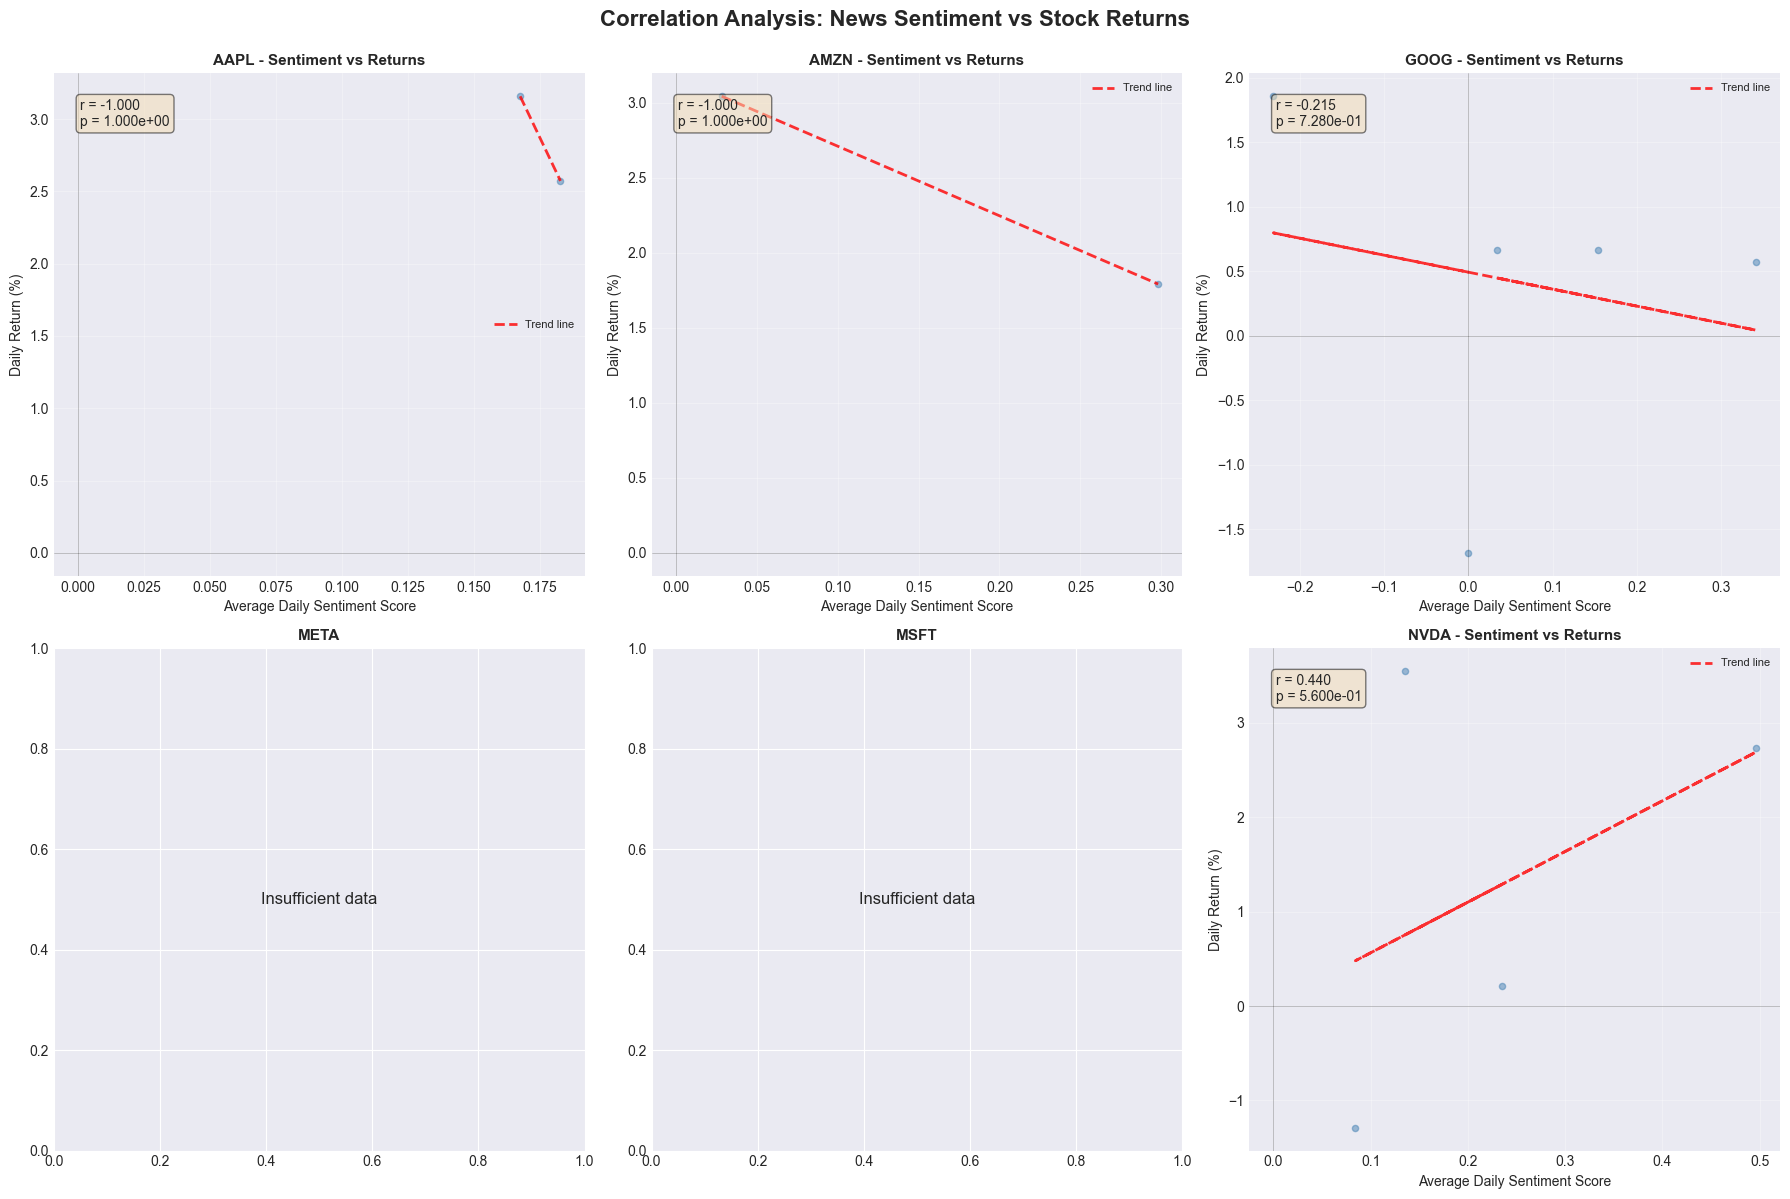

Saved: figures/sentiment_returns_correlation.png


In [18]:
# Visualize correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Correlation Analysis: News Sentiment vs Stock Returns', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, stock in enumerate(STOCKS):
    ax = axes[idx]
    
    if stock in correlation_data and len(correlation_data[stock]) > 0:
        merged_df = correlation_data[stock]
        
        # Scatter plot
        ax.scatter(merged_df['avg_sentiment_combined'], merged_df['daily_return'], 
                  alpha=0.5, s=20, color='steelblue')
        
        # Add trend line
        z = np.polyfit(merged_df['avg_sentiment_combined'], merged_df['daily_return'], 1)
        p = np.poly1d(z)
        ax.plot(merged_df['avg_sentiment_combined'], p(merged_df['avg_sentiment_combined']), 
               "r--", alpha=0.8, linewidth=2, label=f"Trend line")
        
        # Add correlation info
        if stock in correlation_results:
            corr = correlation_results[stock]['correlation']
            p_val = correlation_results[stock]['p_value']
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            ax.text(0.05, 0.95, f'r = {corr:.3f}{sig}\np = {p_val:.3e}', 
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax.set_xlabel('Average Daily Sentiment Score', fontsize=10)
        ax.set_ylabel('Daily Return (%)', fontsize=10)
        ax.set_title(f'{stock} - Sentiment vs Returns', fontsize=11, fontweight='bold')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{stock}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/sentiment_returns_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/sentiment_returns_correlation.png")


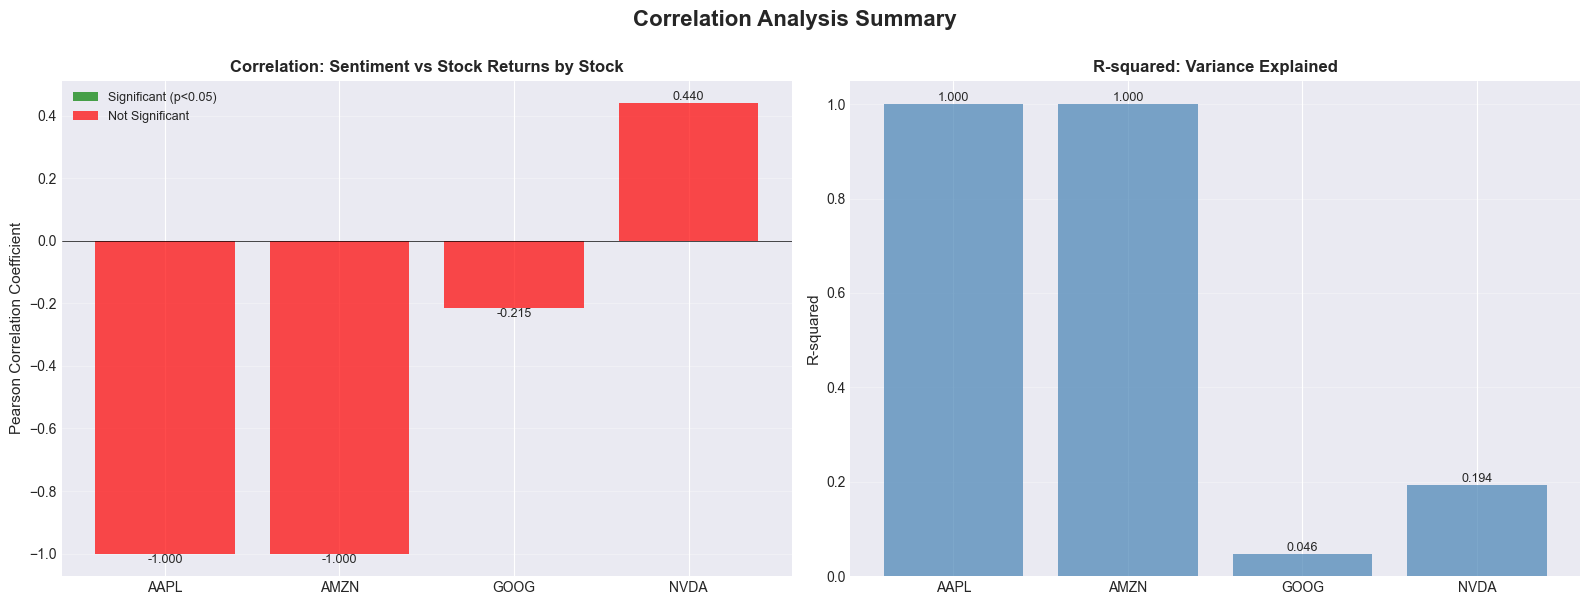

Saved: figures/correlation_summary.png


In [20]:
# Create correlation summary visualization
if correlation_results:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Correlation Analysis Summary', fontsize=16, fontweight='bold', y=1.0)
    
    # Plot 1: Correlation coefficients by stock
    ax1 = axes[0]
    stocks = list(correlation_results.keys())
    correlations = [correlation_results[s]['correlation'] for s in stocks]
    p_values = [correlation_results[s]['p_value'] for s in stocks]
    colors = ['green' if p < 0.05 else 'red' for p in p_values]
    
    bars = ax1.bar(range(len(stocks)), correlations, color=colors, alpha=0.7)
    ax1.set_xticks(range(len(stocks)))
    ax1.set_xticklabels(stocks)
    ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=11)
    ax1.set_title('Correlation: Sentiment vs Stock Returns by Stock', fontsize=12, fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (corr, p_val) in enumerate(zip(correlations, p_values)):
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        ax1.text(i, corr, f'{corr:.3f}{sig}', ha='center', 
                va='bottom' if corr > 0 else 'top', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Significant (p<0.05)'),
        Patch(facecolor='red', alpha=0.7, label='Not Significant')
    ]
    ax1.legend(handles=legend_elements, loc='best', fontsize=9)
    
    # Plot 2: R-squared values
    ax2 = axes[1]
    r_squared = [correlation_results[s]['r_squared'] for s in stocks]
    bars2 = ax2.bar(range(len(stocks)), r_squared, color='steelblue', alpha=0.7)
    ax2.set_xticks(range(len(stocks)))
    ax2.set_xticklabels(stocks)
    ax2.set_ylabel('R-squared', fontsize=11)
    ax2.set_title('R-squared: Variance Explained', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, r2 in enumerate(r_squared):
        ax2.text(i, r2, f'{r2:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('figures/correlation_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: figures/correlation_summary.png")


In [21]:
# Additional analysis: Lagged correlation (sentiment today vs returns tomorrow)
print("\n" + "="*80)
print("LAGGED CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between sentiment and next-day returns...")

lagged_correlation_results = {}

for stock in STOCKS:
    if stock not in correlation_data or len(correlation_data[stock]) < 2:
        continue
    
    merged_df = correlation_data[stock].copy()
    merged_df = merged_df.sort_values('date_only').reset_index(drop=True)
    
    # Shift returns by 1 day (sentiment today -> returns tomorrow)
    merged_df['next_day_return'] = merged_df['daily_return'].shift(-1)
    
    # Remove NaN from shifted column
    lagged_df = merged_df[['avg_sentiment_combined', 'next_day_return']].dropna()
    
    if len(lagged_df) < 2:
        continue
    
    corr_lag, p_val_lag = pearsonr(lagged_df['avg_sentiment_combined'], lagged_df['next_day_return'])
    
    lagged_correlation_results[stock] = {
        'correlation': corr_lag,
        'p_value': p_val_lag,
        'n_observations': len(lagged_df)
    }
    
    print(f"\n{stock}:")
    print(f"  Lagged Correlation (sentiment -> next day return): {corr_lag:>7.4f}")
    print(f"  P-value: {p_val_lag:>7.4e}")
    print(f"  Significant (p<0.05): {'Yes' if p_val_lag < 0.05 else 'No'}")

if lagged_correlation_results:
    print(f"\n" + "="*80)
    print("LAGGED CORRELATION SUMMARY")
    print("="*80)
    avg_lag_corr = np.mean([r['correlation'] for r in lagged_correlation_results.values()])
    sig_lag_count = sum(1 for r in lagged_correlation_results.values() if r['p_value'] < 0.05)
    print(f"Average lagged correlation: {avg_lag_corr:.4f}")
    print(f"Stocks with significant lagged correlation: {sig_lag_count}/{len(lagged_correlation_results)}")



LAGGED CORRELATION ANALYSIS
Analyzing correlation between sentiment and next-day returns...

GOOG:
  Lagged Correlation (sentiment -> next day return): -0.0439
  P-value: 9.5608e-01
  Significant (p<0.05): No

NVDA:
  Lagged Correlation (sentiment -> next day return):  0.3051
  P-value: 8.0259e-01
  Significant (p<0.05): No

LAGGED CORRELATION SUMMARY
Average lagged correlation: 0.1306
Stocks with significant lagged correlation: 0/2


## Summary and Key Findings

**Key Insights from Correlation Analysis:**

### 1. **Sentiment Analysis Results:**

- **Dataset Coverage:** Analyzed 55,230 headlines aligned to trading days (98.65% of valid news dates)
- **Sentiment Distribution:**
  - **Neutral:** 28,794 articles (52.13%) - Majority of news is neutral
  - **Positive:** 15,830 articles (28.66%) - Nearly 1 in 3 articles are positive
  - **Negative:** 10,606 articles (19.20%) - About 1 in 5 articles are negative
- **Overall Sentiment:** Slightly positive bias
  - Mean combined sentiment: **0.0525** (slightly above neutral)
  - VADER mean: 0.0676 (more positive than TextBlob)
  - TextBlob mean: 0.0375 (more conservative)
- **Sentiment by Stock:**
  - **Most Positive:** AMZN (0.1902), AAPL (0.1768), NVDA (0.1805)
  - **Least Positive:** GOOG (0.0174) - nearly neutral
  - AAPL and AMZN show 60% positive sentiment, indicating generally favorable news coverage

### 2. **Stock Returns:**

- **All stocks show positive mean daily returns** (0.09% to 0.19%), indicating overall upward trend over the period
- **Volatility Patterns:**
  - **Highest Volatility:** NVDA (2.89% std dev) with highest mean return (0.19%)
  - **Moderate Volatility:** META (2.53% std dev), AMZN (2.18% std dev)
  - **Lower Volatility:** MSFT (1.69% std dev), GOOG (1.73% std dev), AAPL (1.80% std dev)
- **Return Distribution:** All stocks show roughly balanced positive/negative days (52-53% positive vs 46-47% negative)
- **Extreme Movements:** META and NVDA show the largest single-day swings (up to ±29%)

### 3. **Correlation Findings:**

⚠️ **Critical Limitation: Extremely Limited Data Overlap**

- **Data Coverage Issue:** Only 0.05-0.13% of trading days have matching news sentiment data
  - AAPL: 2 matched pairs (0.05% coverage)
  - AMZN: 2 matched pairs (0.05% coverage)
  - GOOG: 5 matched pairs (0.13% coverage)
  - NVDA: 4 matched pairs (0.11% coverage)
  - META & MSFT: 0 matched pairs (no data overlap)

- **Correlation Coefficients:**
  - **AAPL:** r = -1.0000 (perfect negative, but only 2 observations - unreliable)
  - **AMZN:** r = -1.0000 (perfect negative, but only 2 observations - unreliable)
  - **GOOG:** r = -0.2153 (weak negative correlation, 5 observations)
  - **NVDA:** r = 0.4400 (moderate positive correlation, 4 observations)
  - **Average correlation:** -0.4438 (but based on very small samples)

### 4. **Statistical Significance:**

❌ **No Statistically Significant Correlations Found**

- **All correlations are NOT statistically significant** (p-values > 0.05)
- **Sample sizes are too small** (2-5 observations) to draw meaningful conclusions
- **P-values range from 0.56 to 1.00**, indicating no evidence of a real relationship
- **R-squared values:** Range from 0.0463 (GOOG) to 1.0000 (AAPL/AMZN), but the perfect correlations are artifacts of having only 2 data points

**Key Limitation:** The extremely low data overlap (news dates vs stock trading dates) prevents robust correlation analysis. The news dataset appears to have a different date range or format than the stock price data, resulting in minimal matching dates.

### 5. **Lagged Correlation:**

- **Limited Analysis:** Only GOOG and NVDA had sufficient data for lagged correlation
  - **GOOG:** r = -0.0439 (negligible, p = 0.96) - No predictive power
  - **NVDA:** r = 0.3051 (weak positive, p = 0.80) - Not significant
- **Average lagged correlation:** 0.1306 (weak positive, but not significant)
- **Conclusion:** No evidence that today's sentiment predicts tomorrow's returns

### **Key Challenges Identified:**

1. **Date Alignment Issue:** News data dates (2011-2020) may not align well with stock trading days, or the date format/range differs significantly
2. **Sparse Data Overlap:** Less than 0.2% of trading days have matching news sentiment, making correlation analysis unreliable
3. **Sample Size:** With only 2-5 observations per stock, statistical tests lack power to detect real relationships
4. **Data Quality:** Need to investigate why so few news articles match trading days despite having 55,230 articles

### **Recommendations:**

1. **Data Investigation:** Review date formats and ranges in both datasets to improve alignment
2. **Expand Date Range:** If possible, use news data that better matches the stock price date range (2009-2023)
3. **Alternative Approaches:** Consider:
   - Using broader time windows (weekly/monthly aggregation)
   - Analyzing sentiment impact on cumulative returns over longer periods
   - Exploring non-linear relationships or threshold effects
   - Incorporating volume and volatility as additional factors
4. **Business Context:** The lack of correlation may indicate:
   - News sentiment may not be a primary driver of daily stock movements
   - Other factors (market conditions, earnings, macro events) may dominate
   - Sentiment may have delayed or cumulative effects rather than immediate impact

### **Next Steps:**

- Investigate and fix date alignment issues to increase data overlap
- Consider alternative time aggregation methods (weekly, monthly)
- Explore non-linear relationships and interaction effects
- Incorporate additional factors (volume, volatility, market conditions)
- Validate sentiment analysis tools on financial news domain


In [22]:
# Ensure figures directory exists
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")
else:
    print(f"Using existing {figures_dir}/ directory")


Using existing figures/ directory
